In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [2]:
from autoencodix.utils.example_data import (
    EXAMPLE_MULTI_BULK,
    EXAMPLE_MULTI_SC,
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA
raw_bulk = EXAMPLE_MULTI_BULK
raw_sc = EXAMPLE_MULTI_SC

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
EXAMPLE_PROCESSED_DATA.train.metadata

,cluster,age,size,density,category,random_feature,sample_id
sample_303,Cluster_1,21.194224,4.538300,0.113699,A,-0.657083,sample_303
sample_259,Cluster_1,23.930016,6.864434,0.086318,A,1.280058,sample_259
sample_717,Cluster_4,53.074559,12.812042,1.111816,D,-0.046288,sample_717
sample_127,Cluster_5,53.380117,12.875572,0.525779,C,0.578705,sample_127
sample_576,Cluster_1,33.724569,2.429471,0.038608,B,0.657419,sample_576
...,...,...,...,...,...,...,...
sample_578,Cluster_1,28.165998,6.223125,0.286763,E,0.047880,sample_578
sample_946,Cluster_2,31.830988,4.929979,0.456122,B,0.126054,sample_946
sample_284,Cluster_3,40.607502,6.923138,2.313312,B,-0.288755,sample_284
sample_462,Cluster_1,40.449944,0.831899,0.096780,C,1.070726,sample_462


In [4]:
import autoencodix as acx
from autoencodix.utils.default_config import DefaultConfig

preprocessing
Epoch 1 - Train Loss: 840489.1133
Sub-losses: recon_loss: 840489.1133
Epoch 1 - Valid Loss: 113938.0085
Sub-losses: recon_loss: 113938.0085
Epoch 2 - Train Loss: 769611.0195
Sub-losses: recon_loss: 769611.0195
Epoch 2 - Valid Loss: 102112.4814
Sub-losses: recon_loss: 102112.4814
Epoch 3 - Train Loss: 696815.0156
Sub-losses: recon_loss: 696815.0156
Epoch 3 - Valid Loss: 90086.9753
Sub-losses: recon_loss: 90086.9753
Epoch 4 - Train Loss: 626703.7852
Sub-losses: recon_loss: 626703.7852
Epoch 4 - Valid Loss: 81164.8928
Sub-losses: recon_loss: 81164.8928
Epoch 5 - Train Loss: 571475.1387
Sub-losses: recon_loss: 571475.1387
Epoch 5 - Valid Loss: 74864.5598
Sub-losses: recon_loss: 74864.5598
Epoch 6 - Train Loss: 529779.4375
Sub-losses: recon_loss: 529779.4375
Epoch 6 - Valid Loss: 69795.5925
Sub-losses: recon_loss: 69795.5925
Epoch 7 - Train Loss: 502964.3145
Sub-losses: recon_loss: 502964.3145
Epoch 7 - Valid Loss: 64983.6154
Sub-losses: recon_loss: 64983.6154
Epoch 8 - Train 

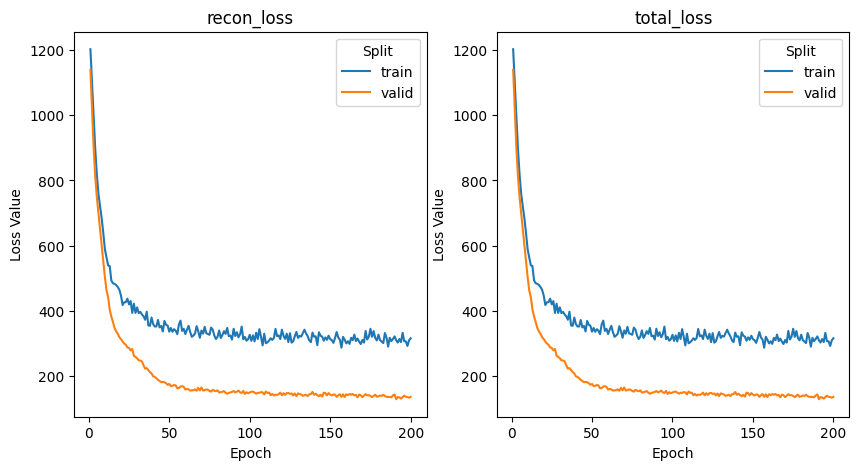

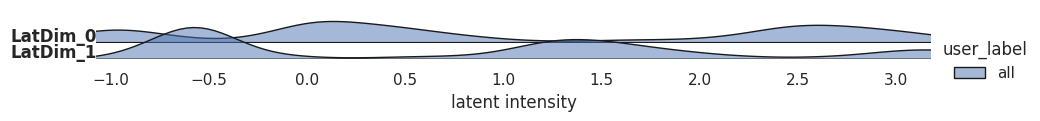

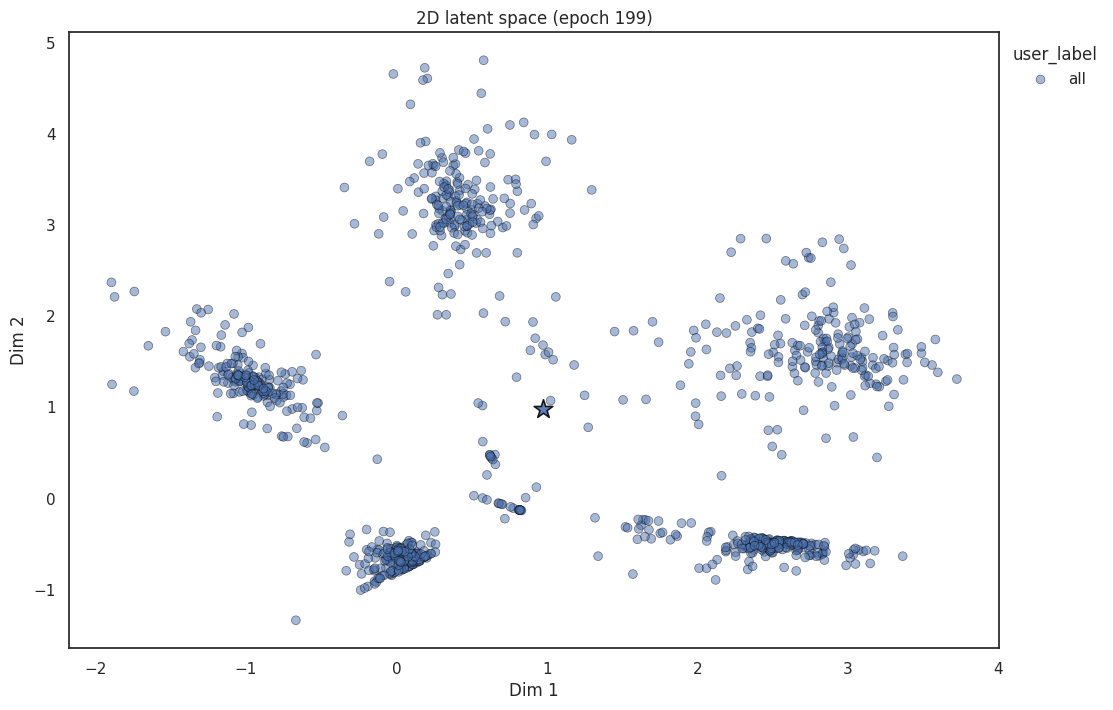

In [5]:
vanillix = acx.Vanillix(config=DefaultConfig(epochs=200, learning_rate=0.005,n_layers=1, latent_dim=2, checkpoint_interval=50), data=processed_data)
vanillix.run()
vanillix.show_result()

In [6]:
## Not needed anymore since in-built in visualizer

# categorical_clusters = ["Cluster_"+str(c) for c in EXAMPLE_PROCESSED_DATA.train.metadata.cluster]
# categorical_clusters

In [7]:
vanillix.result.datasets.train.metadata.index

Index(['sample_303', 'sample_259', 'sample_717', 'sample_127', 'sample_576',
       'sample_960', 'sample_492', 'sample_581', 'sample_359', 'sample_781',
       ...
       'sample_733', 'sample_582', 'sample_337', 'sample_100', 'sample_405',
       'sample_578', 'sample_946', 'sample_284', 'sample_462', 'sample_391'],
      dtype='object', length=699)

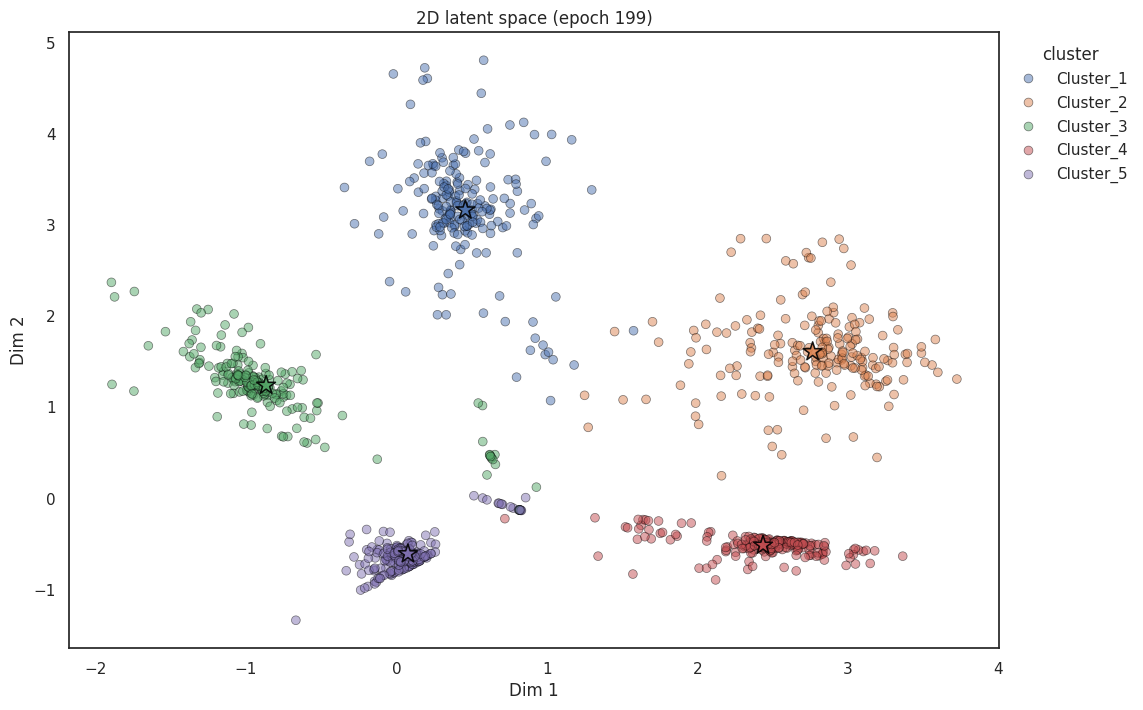

In [8]:
vanillix._visualizer.show_latent_space(result=vanillix.result,plot_type="2D-scatter", param=["cluster"])

## Ontix

In [9]:
import autoencodix as acx
from autoencodix.utils.default_config import DefaultConfig

from autoencodix.utils.example_data import (
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA


In [10]:

ont_lvl1 = dict()
ont_lvl2 = dict()

ont_lvl1["pwy-1"] = ["sub-pwy-1", "sub-pwy-2"]
ont_lvl1["pwy-2"] = ["sub-pwy-2"]
ont_lvl1["pwy-3"] = ["sub-pwy-1", "sub-pwy-3"]
# first third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-1"] = processed_data.train.feature_ids[: int(len(processed_data.train.feature_ids) / 3)]
# second third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-2"] = processed_data.train.feature_ids[
	int(len(processed_data.train.feature_ids) / 3) : int(2 * len(processed_data.train.feature_ids) / 3)
]
# last third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-3"] = processed_data.train.feature_ids[
	int(2 * len(processed_data.train.feature_ids) / 3) : int(len(processed_data.train.feature_ids))
]

# ont_lvl2["sub-pwy-1"] = ["gene-1", "gene-2"]
# ont_lvl2["sub-pwy-2"] = ["gene-3", "gene-4"]
# ont_lvl2["sub-pwy-3"] = ["gene-2", "gene-6"]

ontology_tuple = ( ont_lvl1, ont_lvl2 )


In [11]:
# Write each dictionary in ontology_tuple to a separate text file
for i, ont_dict in enumerate(ontology_tuple):
	file_name = f"ontology_level_{i+1}.txt"
	with open(file_name, "w") as f:
		for key, values in ont_dict.items():
			for value in values:
				f.write(f"{value}\t{key}\n")
print("Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt")

Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt


In [12]:
ont_files = ["ontology_level_1.txt", "ontology_level_2.txt"]

In [13]:
ontix = acx.Ontix(ontologies=ont_files, sep="\t", config=DefaultConfig(epochs=20, learning_rate=0.005,n_layers=1), data=processed_data)
# ontix = acx.Ontix(ontologies=ontology_tuple, config=DefaultConfig(epochs=500, learning_rate=0.005,n_layers=1), user_data=processed_data)

In [14]:
ontix.run()

preprocessing
Ontix checks:
All possible feature names length: 30
Feature order length: 30
Feature names without filtering: 30
Mask layer 0 with shape torch.Size([3, 3]) and 5.0 connections
Mask layer 1 with shape torch.Size([30, 3]) and 30.0 connections
Latent Dim: 3
Epoch 1 - Train Loss: 855757.0801
Sub-losses: recon_loss: 855757.0742, var_loss: 523.9801, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 119710.8896
Sub-losses: recon_loss: 119710.8779, var_loss: 232.9575, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 817756.3457
Sub-losses: recon_loss: 817756.0859, var_loss: 2185.9980, anneal_factor: 0.0001, effective_beta_factor: 0.0001
Epoch 2 - Valid Loss: 108972.8459
Sub-losses: recon_loss: 108972.7676, var_loss: 651.9610, anneal_factor: 0.0001, effective_beta_factor: 0.0001
Epoch 3 - Train Loss: 724640.6719
Sub-losses: recon_loss: 724638.5332, var_loss: 6366.3504, anneal_factor: 0.0003, effective_beta_factor: 0.0003
Epoch 3 -

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: OntixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x71b18aa56aa0>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x71b18a9908b0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x71b18a990af0>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 201 × 3
    uns: 'var_names'
final_reconstruc

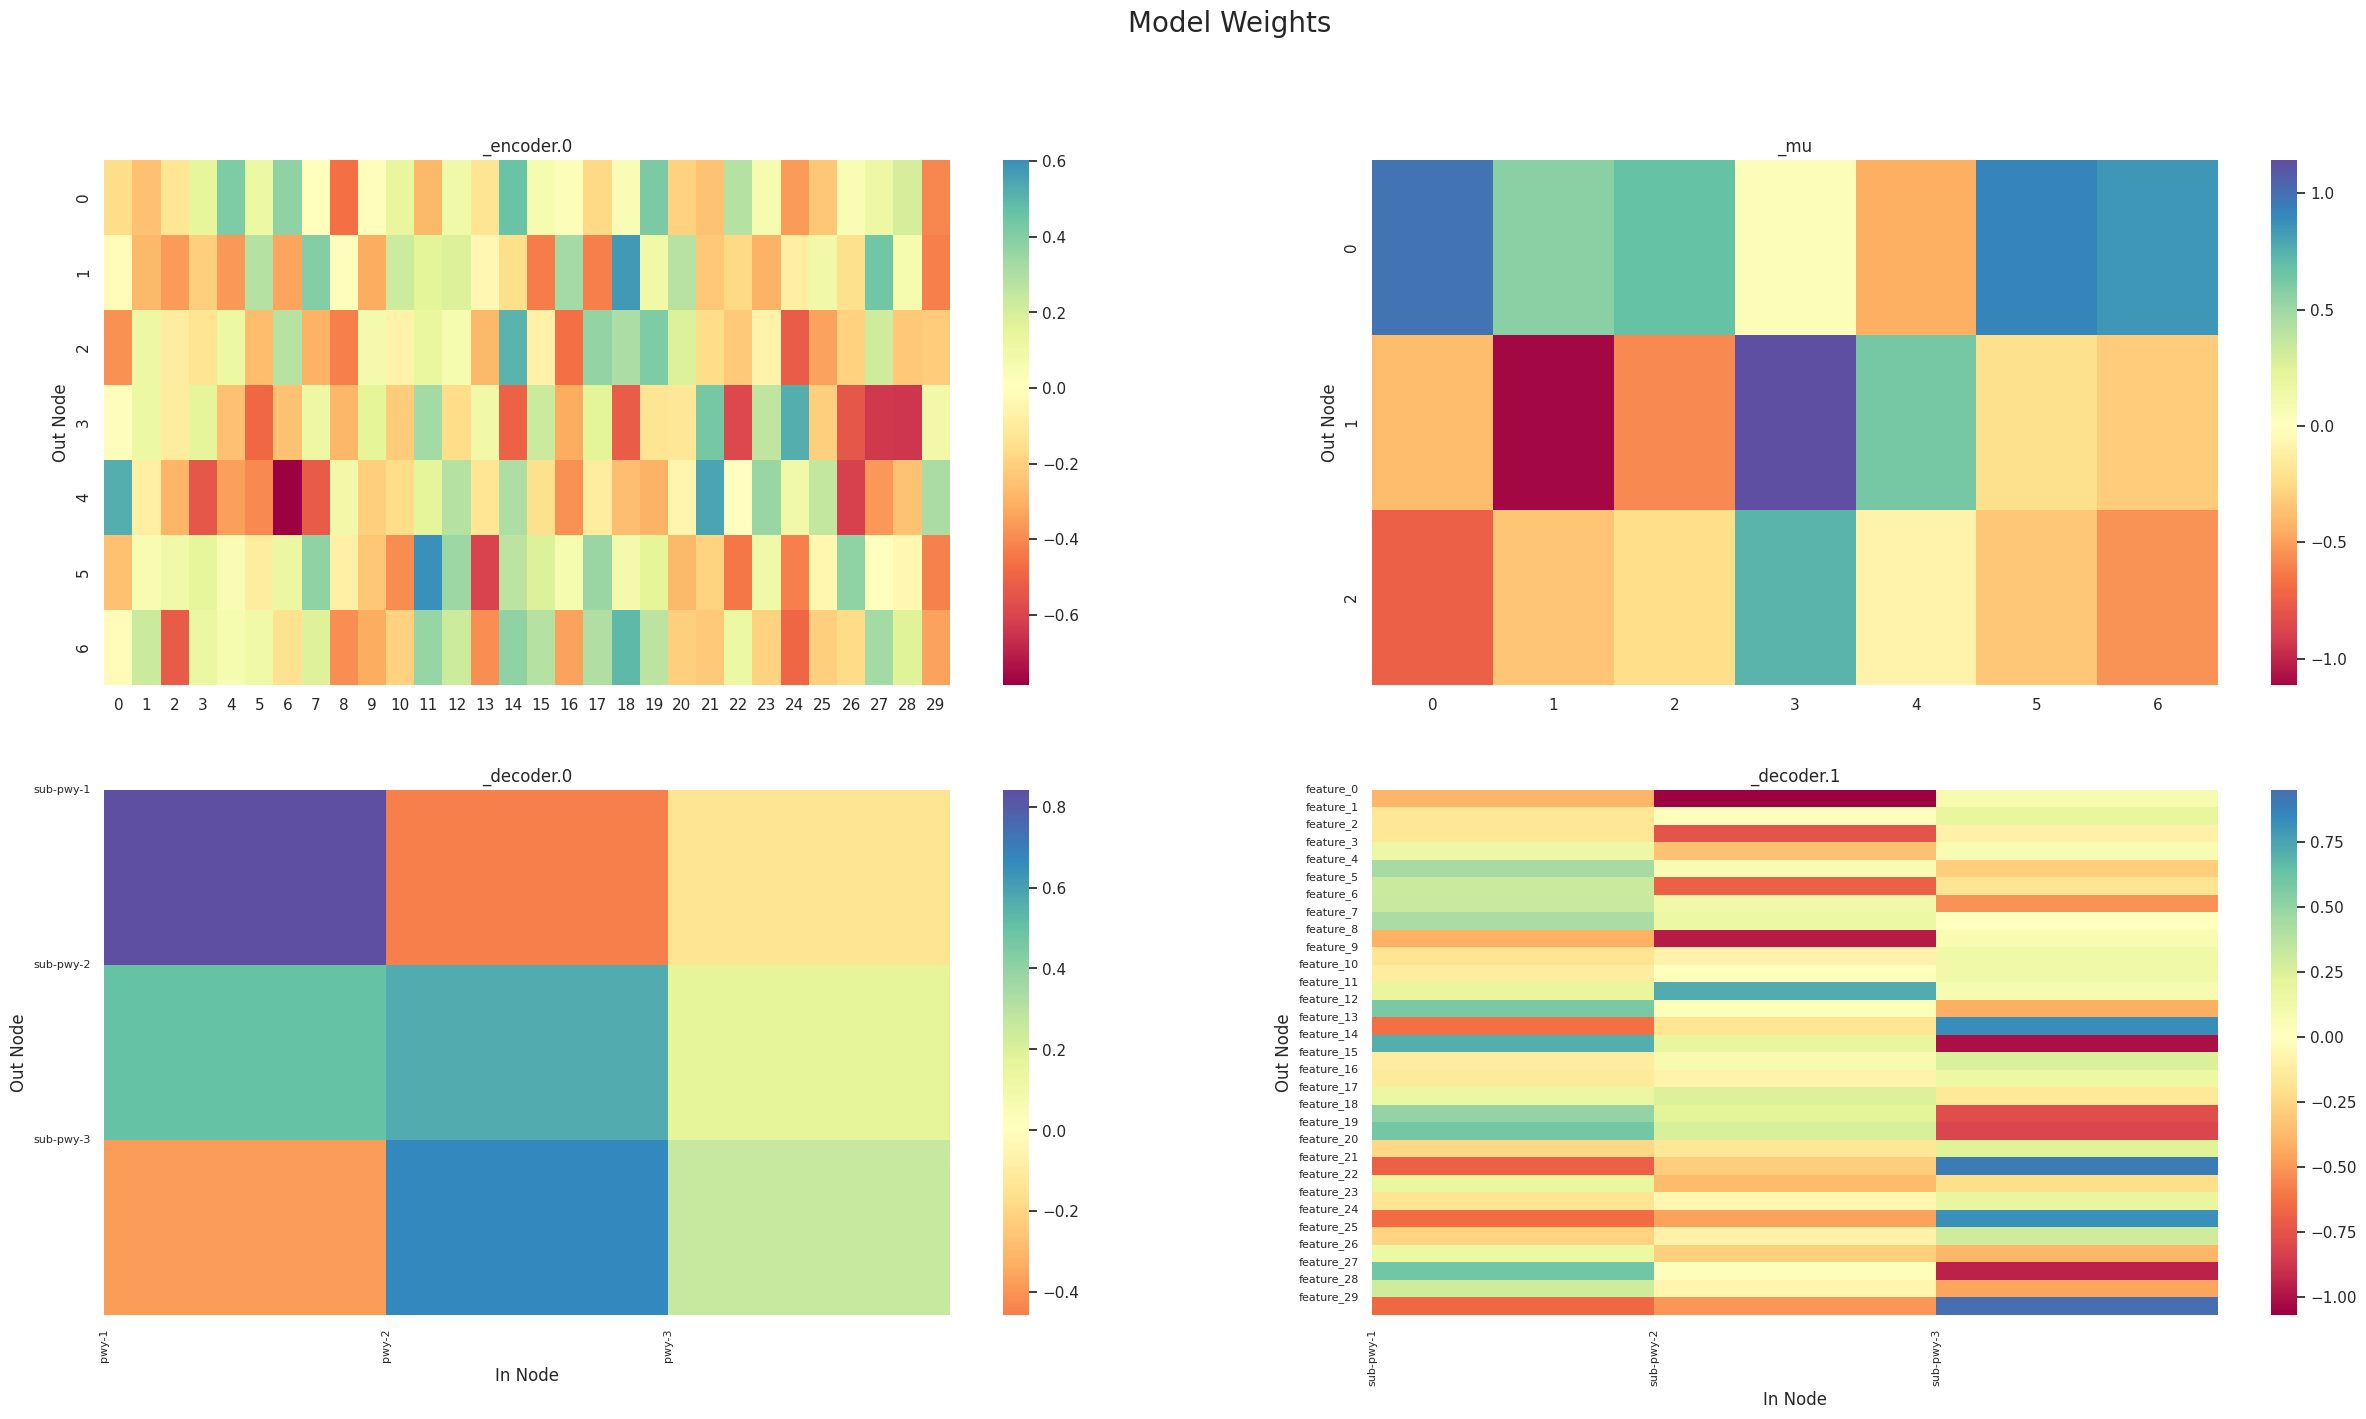

In [15]:
ontix._visualizer.show_weights()

Creating plots ...


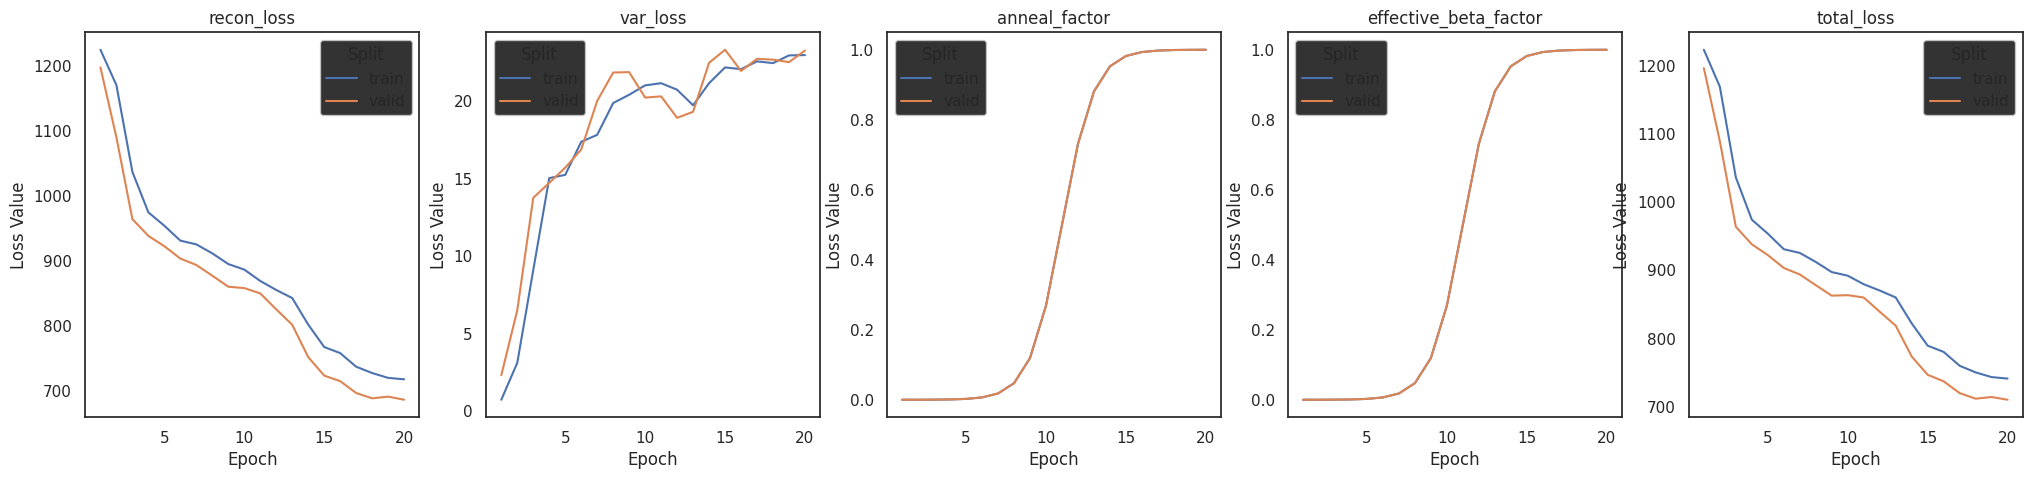

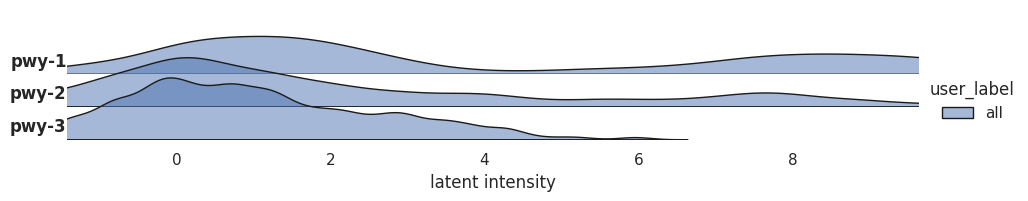

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


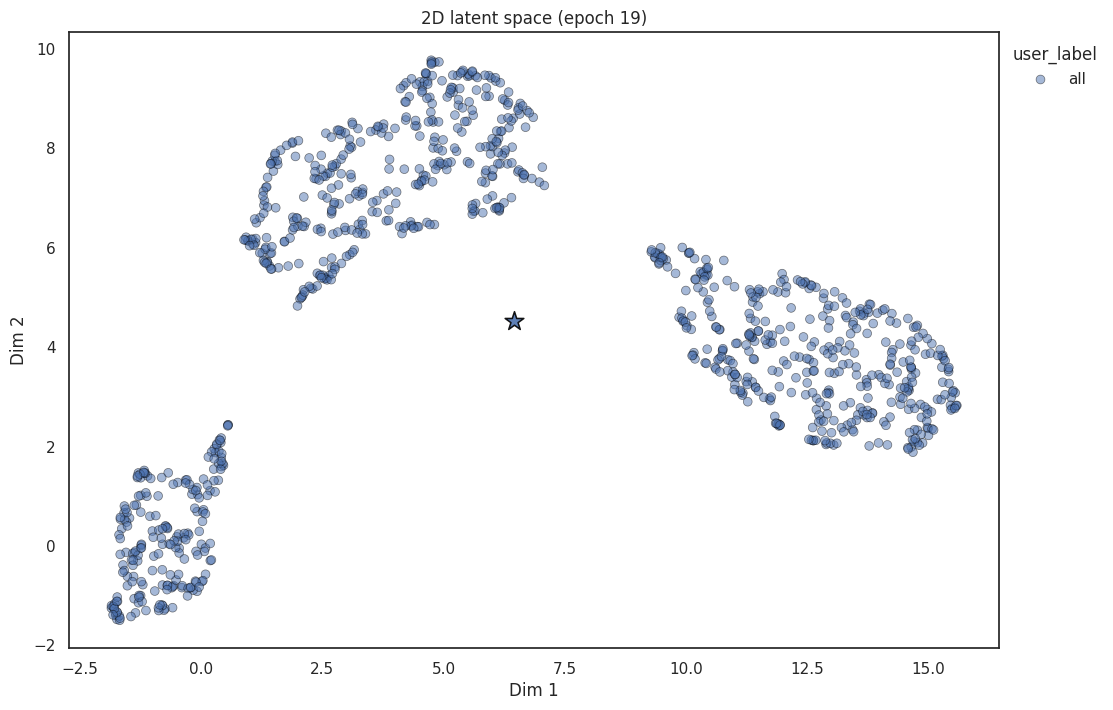

In [16]:
ontix.show_result()

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


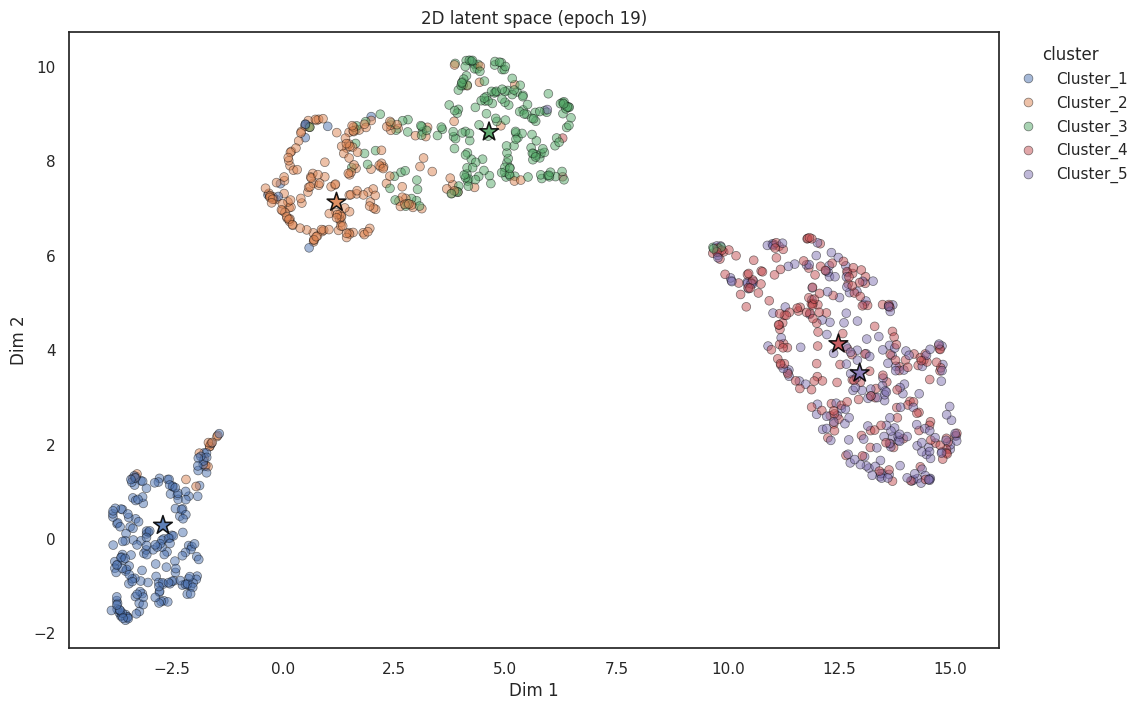

In [17]:
# categorical_clusters = ["Cluster_"+str(c) for c in EXAMPLE_PROCESSED_DATA.train.metadata.cluster]
# categorical_clusters
ontix._visualizer.show_latent_space(result=ontix.result,plot_type="2D-scatter", split="all", param=["cluster"])

In [18]:
ontix.ontologies

({'pwy-1': ['sub-pwy-1', 'sub-pwy-2'],
  'pwy-2': ['sub-pwy-2'],
  'pwy-3': ['sub-pwy-1', 'sub-pwy-3']},
 {'sub-pwy-1': ['feature_0',
   'feature_1',
   'feature_2',
   'feature_3',
   'feature_4',
   'feature_5',
   'feature_6',
   'feature_7',
   'feature_8',
   'feature_9'],
  'sub-pwy-2': ['feature_10',
   'feature_11',
   'feature_12',
   'feature_13',
   'feature_14',
   'feature_15',
   'feature_16',
   'feature_17',
   'feature_18',
   'feature_19'],
  'sub-pwy-3': ['feature_20',
   'feature_21',
   'feature_22',
   'feature_23',
   'feature_24',
   'feature_25',
   'feature_26',
   'feature_27',
   'feature_28',
   'feature_29']})

In [19]:
enumerate(ontix.result.model.ontologies)

In [20]:
ontix.result.model.ontologies[1].keys()

dict_keys(['sub-pwy-1', 'sub-pwy-2', 'sub-pwy-3'])

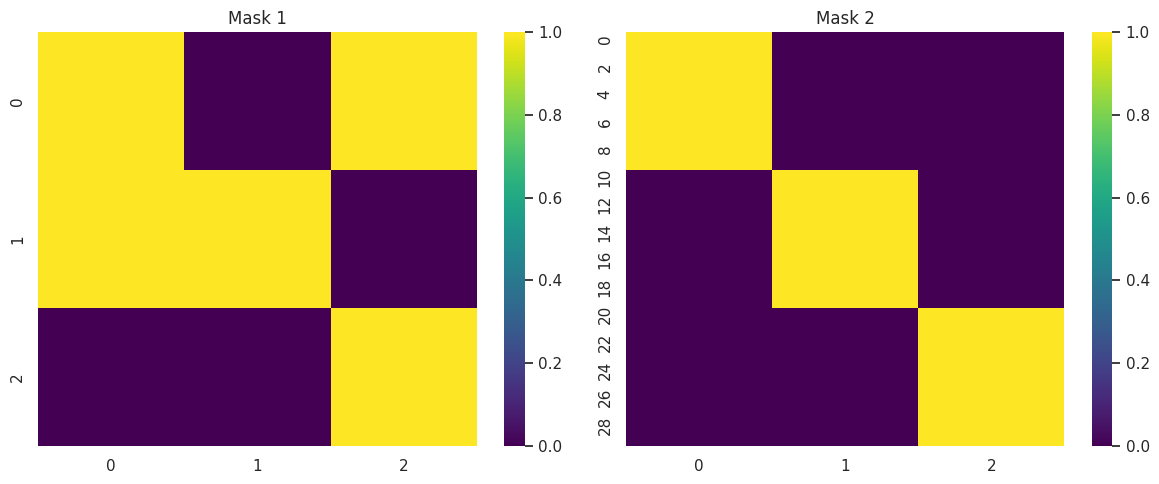

In [21]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

masks = ontix.result.model.masks

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, mask in enumerate(masks):
	sns.heatmap(np.array(mask), ax=axes[i], cmap="viridis")
	axes[i].set_title(f"Mask {i+1}")
plt.tight_layout()
plt.show()